<a href="https://colab.research.google.com/github/cbeckler/eco_cancer_incidence_rates/blob/kp_dashboard/SMOTE_Visualization_Balanced_Random_Forest_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,377 kB]
Get:13 http://archive.ubuntu

In [2]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2023-01-22 23:11:23--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar’

postgresql-42.2.16. 100%[===================>] 979.38K  1.59MB/s    in 0.6s    

2023-01-22 23:11:24 (1.59 MB/s) - ‘postgresql-42.2.16.jar’ saved [1002883/1002883]



In [3]:
# start spark session 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("balanced_random_forest").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#connect to database

import pandas as pd

conn_path = "/content/drive/MyDrive/data/db_conn_info.csv"

conn_info = pd.read_csv(conn_path)

db_name = conn_info['db_name'][0]

db_pw = conn_info['password'][0]

db_host = conn_info['host'][0]

db_port = conn_info['port'][0]

db_user = conn_info['user'][0]

In [6]:
from sqlalchemy import create_engine

engine = create_engine(f'postgresql://{db_name}:{db_pw}@{db_host}:{db_port}/{db_user}')

In [7]:
# import model dataset

df = pd.read_sql("select * from model_dataset", engine)

df.head()

,index,FIPS,recent_trend,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred,PM25_max_pred_2001,...,O3_med_pred_2005,O3_med_pred_2006,O3_med_pred_2007,O3_med_pred_2008,O3_med_pred_2009,O3_med_pred_2010,O3_med_pred_2011,O3_med_pred_2012,O3_med_pred_2013,O3_med_pred_2014
0,0,01001,stable,12.239594,11.870589,11.787900,41.001571,39.948742,39.921898,13.186807,...,40.529218,43.681686,43.838816,40.486148,36.221797,41.289135,40.862455,39.302231,36.364677,37.080065
1,1,01003,stable,11.024418,9.822870,9.794272,45.070022,41.241604,41.341833,12.520190,...,43.565735,45.922312,43.525804,40.236525,38.505225,42.373774,42.022552,39.985824,37.438556,38.104659
2,2,01005,stable,11.688170,11.099414,11.084238,41.139416,40.185889,40.162437,12.364383,...,40.585246,43.720973,43.837824,41.187681,37.317680,41.459194,41.776717,39.300123,36.652613,37.449995
3,3,01007,stable,12.280141,11.700512,11.721958,40.505549,39.399455,39.389288,13.944184,...,41.133554,43.764713,43.850361,39.875838,35.059151,39.827738,39.680734,38.873873,35.961584,36.127933
4,4,01009,stable,13.498799,12.690525,12.741736,42.714107,41.096201,41.085945,16.032861,...,41.301827,43.677824,45.038788,41.869574,37.462589,42.542686,41.728563,41.646953,37.739042,38.077132


In [8]:
import numpy as np
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


## Create Features and target variable

In [9]:
X = df.drop(['index', 'FIPS', 'recent_trend'], axis=1)
y = df['recent_trend']

In [10]:
features=X.columns

In [11]:
y.value_counts()

stable     2410
falling     198
rising       43
Name: recent_trend, dtype: int64

## Data split into Training and Testing

In [12]:
#Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1,
                                                    train_size=0.85,
                                                    stratify=y)
scaler =StandardScaler().fit(X_train)

X_train_scaled =scaler.transform(X_train)
X_test_scaled =scaler.transform(X_test)

## Data resampled with SMOTE

In [13]:
y_train.value_counts()

stable     2048
falling     168
rising       37
Name: recent_trend, dtype: int64

In [14]:
# Resampling training data with SMOTE
X_resampled, y_resampled = SMOTE(
    random_state=1,sampling_strategy='auto').fit_resample(
    X_train_scaled, y_train)

print(f'y_resampled: {Counter(y_resampled)}')

y_resampled: Counter({'stable': 2048, 'rising': 2048, 'falling': 2048})


## Balanced Random Forest Classifier 

In [15]:
from imblearn.ensemble import BalancedRandomForestClassifier
brc=BalancedRandomForestClassifier(random_state=1, n_estimators=100).fit(X_resampled, y_resampled)

In [16]:
y_pred= brc.predict(X_test_scaled)

In [17]:
y_pred_train= brc.predict(X_train_scaled)

## Balanced Accuracy Score

In [18]:
# Balanced accuracy training score 
balanced_accuracy_score(y_train, y_pred_train)

1.0

In [19]:
# Balanced accuracy testign score
balanced_accuracy_score(y_test, y_pred)


0.4020257826887661

## Confusion Matrix

In [20]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[  9,   0,  21],
       [  0,   0,   6],
       [ 27,   7, 328]])

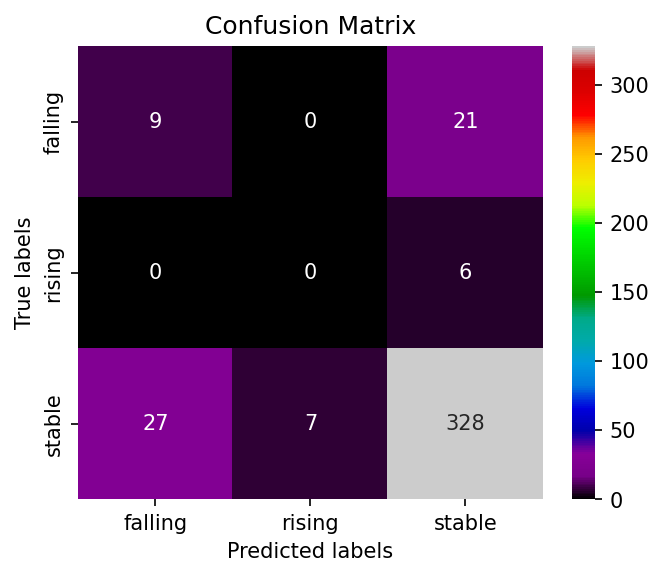

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt     
fig, axes = plt.subplots(figsize = (5,4), dpi=150)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="nipy_spectral"); #"cividis","nipy_spectral","GnBu_r","jet","PuBu_r","Spectral_r","gnuplot","gist_ncar","gist_heat_r","gist_earth_r","inferno_r","RdYlBu","coolwarm",Spectral,"PRGn","PiYG"#annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['falling', 'rising','stable']); ax.yaxis.set_ticklabels(['falling', 'rising','stable']);
plt.savefig('/content/drive/MyDrive/Final_Project/confusion_matrix.png')

In [22]:
brc_df=pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
brc_df.head()

,Prediction,Actual
0,stable,stable
1,stable,stable
2,stable,falling
3,stable,stable
4,stable,stable


In [23]:
print(brc_df.Prediction.value_counts())
print(brc_df.Actual.value_counts())

stable     355
falling     36
rising       7
Name: Prediction, dtype: int64
stable     362
falling     30
rising       6
Name: Actual, dtype: int64


## Imbalanced Classification Report

In [24]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

    falling       0.25      0.30      0.93      0.27      0.53      0.26        30
     rising       0.00      0.00      0.98      0.00      0.00      0.00         6
     stable       0.92      0.91      0.25      0.91      0.48      0.24       362

avg / total       0.86      0.85      0.31      0.85      0.47      0.24       398



# Resampling with SMOTE

## Classes before resampling 

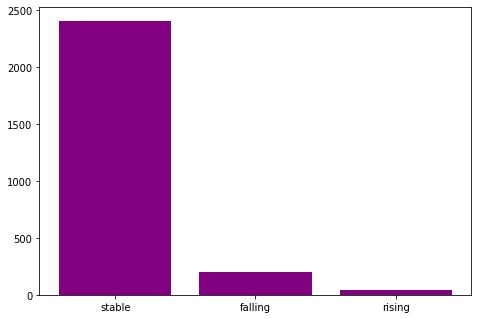

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1],)
values =['stable', 'falling', 'rising']
y = [2410, 198, 43]
ax.bar(values,y,color = "purple") #"xkcd:easter purple"
plt.show()

### Y train before resampling

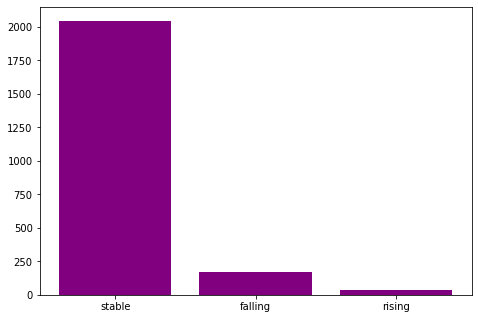

<Figure size 432x288 with 0 Axes>

In [27]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1],)
values =['stable', 'falling', 'rising']
y = [2048, 168, 37]
ax.bar(values,y,color = "purple")
plt.show()
plt.savefig('/content/drive/MyDrive/Final_Project/classes_before_resampling')

## Classes after resampling with SMOTE

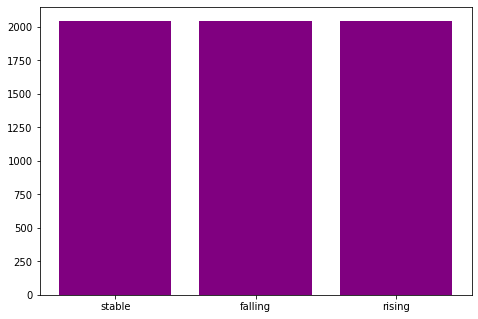

<Figure size 432x288 with 0 Axes>

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1],)
values =['stable', 'falling', 'rising']
y = [2048, 2048, 2048]
ax.bar(values,y,color = "purple")
plt.show()
plt.savefig('/content/drive/MyDrive/Final_Project/classes_after_resampling')

# Predictions with trained model 

In [30]:
scaler =StandardScaler().fit(X)
X_scaled =scaler.transform(X)

In [31]:
prediction_trend= brc.predict(X_scaled)

In [32]:
prediction_trend

array(['stable', 'stable', 'stable', ..., 'stable', 'stable', 'stable'],
      dtype=object)

In [33]:
df.head()
# df.to_csv('/content/drive/MyDrive/Final_Project/df.csv')

,index,FIPS,recent_trend,PM25_max_pred,PM25_med_pred,PM25_mean_pred,O3_max_pred,O3_med_pred,O3_mean_pred,PM25_max_pred_2001,...,O3_med_pred_2005,O3_med_pred_2006,O3_med_pred_2007,O3_med_pred_2008,O3_med_pred_2009,O3_med_pred_2010,O3_med_pred_2011,O3_med_pred_2012,O3_med_pred_2013,O3_med_pred_2014
0,0,01001,stable,12.239594,11.870589,11.787900,41.001571,39.948742,39.921898,13.186807,...,40.529218,43.681686,43.838816,40.486148,36.221797,41.289135,40.862455,39.302231,36.364677,37.080065
1,1,01003,stable,11.024418,9.822870,9.794272,45.070022,41.241604,41.341833,12.520190,...,43.565735,45.922312,43.525804,40.236525,38.505225,42.373774,42.022552,39.985824,37.438556,38.104659
2,2,01005,stable,11.688170,11.099414,11.084238,41.139416,40.185889,40.162437,12.364383,...,40.585246,43.720973,43.837824,41.187681,37.317680,41.459194,41.776717,39.300123,36.652613,37.449995
3,3,01007,stable,12.280141,11.700512,11.721958,40.505549,39.399455,39.389288,13.944184,...,41.133554,43.764713,43.850361,39.875838,35.059151,39.827738,39.680734,38.873873,35.961584,36.127933
4,4,01009,stable,13.498799,12.690525,12.741736,42.714107,41.096201,41.085945,16.032861,...,41.301827,43.677824,45.038788,41.869574,37.462589,42.542686,41.728563,41.646953,37.739042,38.077132


In [34]:
df['prediction_trend'] = prediction_trend

print(df.recent_trend.value_counts())
print(df.prediction_trend.value_counts())

stable     2410
falling     198
rising       43
Name: recent_trend, dtype: int64
stable     2396
falling     207
rising       48
Name: prediction_trend, dtype: int64


## Feature importances

In [35]:
# List the features sorted in descending order by feature importance
features = sorted(zip(X.columns, brc.feature_importances_), reverse= True, key = lambda x: x[1])
for feature in features:
    print(f'{feature[0]}:{feature[1]}')

O3_med_pred_2003:0.020803800876859735
O3_mean_pred_2006:0.019895580717086307
O3_max_pred_2009:0.01958363518649273
O3_mean_pred_2009:0.01915729525883204
O3_mean_pred_2003:0.019070106825551138
O3_max_pred_2004:0.018944648007022474
O3_max_pred_2014:0.01729743287343924
O3_max_pred_2013:0.01718957623660117
O3_max_pred_2006:0.016688688919408234
O3_med_pred_2006:0.016611729713014303
O3_max_pred_2008:0.016349334292813954
O3_mean_pred_2013:0.016150481203634083
O3_med_pred_2009:0.015959225337320315
O3_max_pred_2001:0.015931999804359505
O3_max_pred_2002:0.015191312496834072
O3_med_pred_2004:0.01498434622216158
O3_mean_pred_2004:0.014883295881810725
O3_mean_pred_2005:0.014789726403559088
O3_med_pred_2013:0.014217253947009125
O3_med_pred_2005:0.013836058540181582
PM25_max_pred_2007:0.013351992922036865
PM25_max_pred_2014:0.01299114422285684
O3_med_pred_2011:0.012985537283610007
O3_mean_pred_2001:0.012828372601575206
O3_mean_pred_2011:0.012824525535198816
PM25_max_pred_2011:0.012688137971529432
O3_m

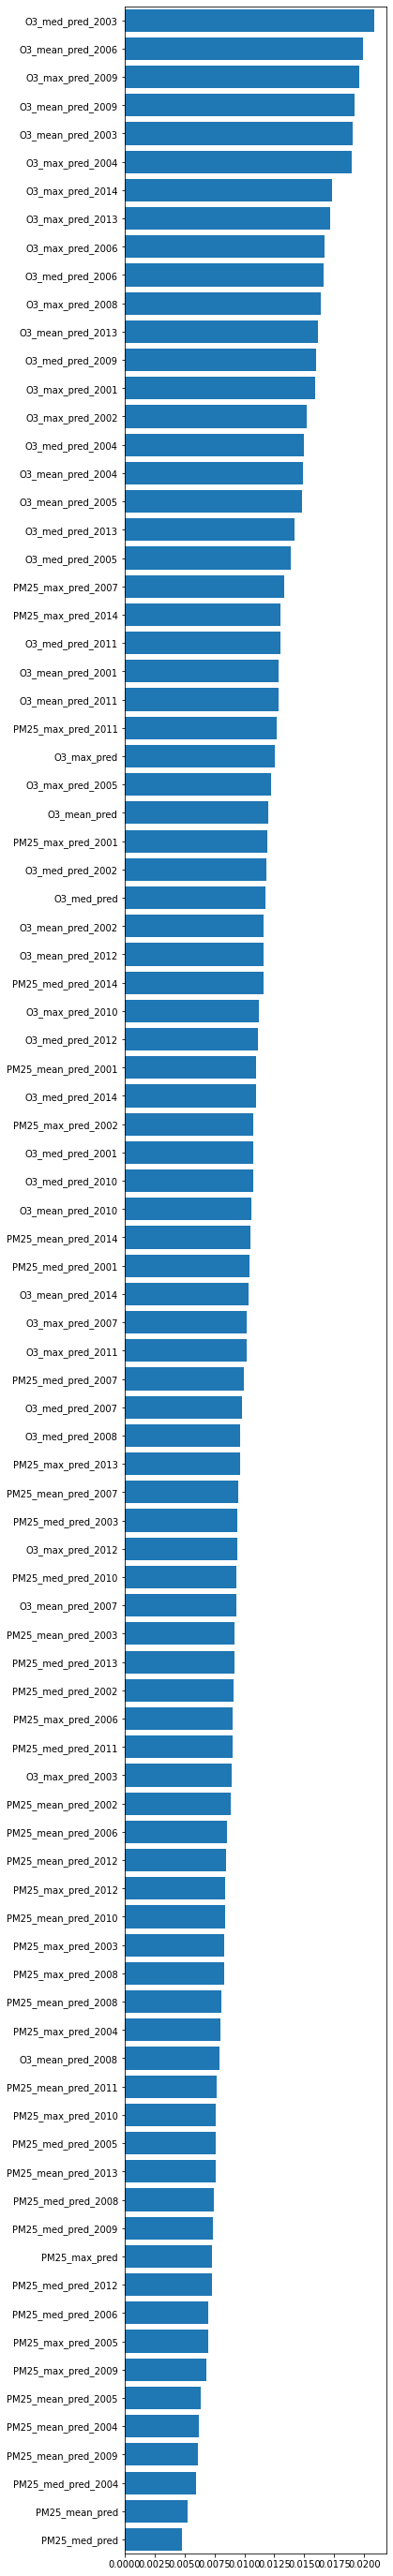

In [36]:
features = sorted(zip(X.columns, brc.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(5,50)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)
# plt.savefig('/content/drive/MyDrive/Final_Project/Feature_Importances')
plt.show()

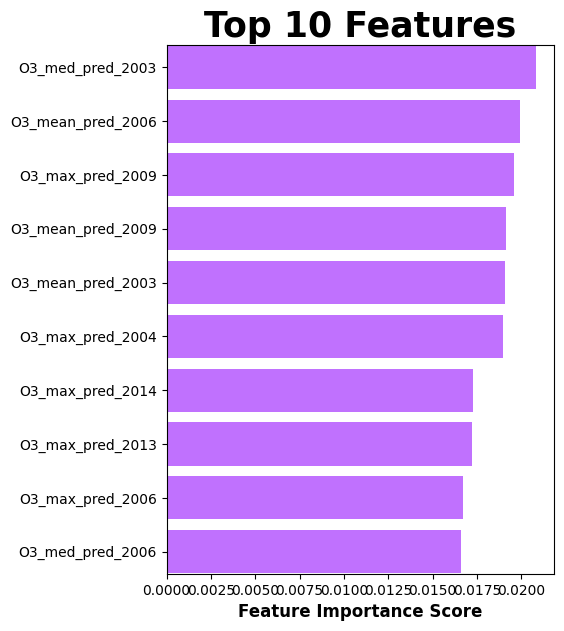

In [37]:
# graph with top 10 features
features = sorted(zip(X.columns, brc.feature_importances_), key = lambda x: x[1])

features_df = pd.DataFrame(features, columns=['feature', 'score'])

features_df = features_df.sort_values(by='score', ascending=False)

top_features = features_df.head(10)

top_features = top_features.sort_values(by='score')

cols = top_features['feature']
width = top_features['score']

fig, ax = plt.subplots(figsize = (2,2), dpi=100)

fig.set_size_inches(5,7)
plt.margins(y=0.001)

ax.barh(y=cols, width=width, color = "xkcd:easter purple") # slategrey, grey, darkgray, xkcd:very dark purple,eggplant


ax.set_title("Top 10 Features",fontdict={'fontsize': 25, 'fontweight': 'semibold'})
ax.set_xlabel("Feature Importance Score",fontdict={'fontsize': 12, 'fontweight': 'semibold'})

# plt.savefig('/content/drive/MyDrive/Final_Project/Feature_Importances_top10_SMOTE')
plt.show()

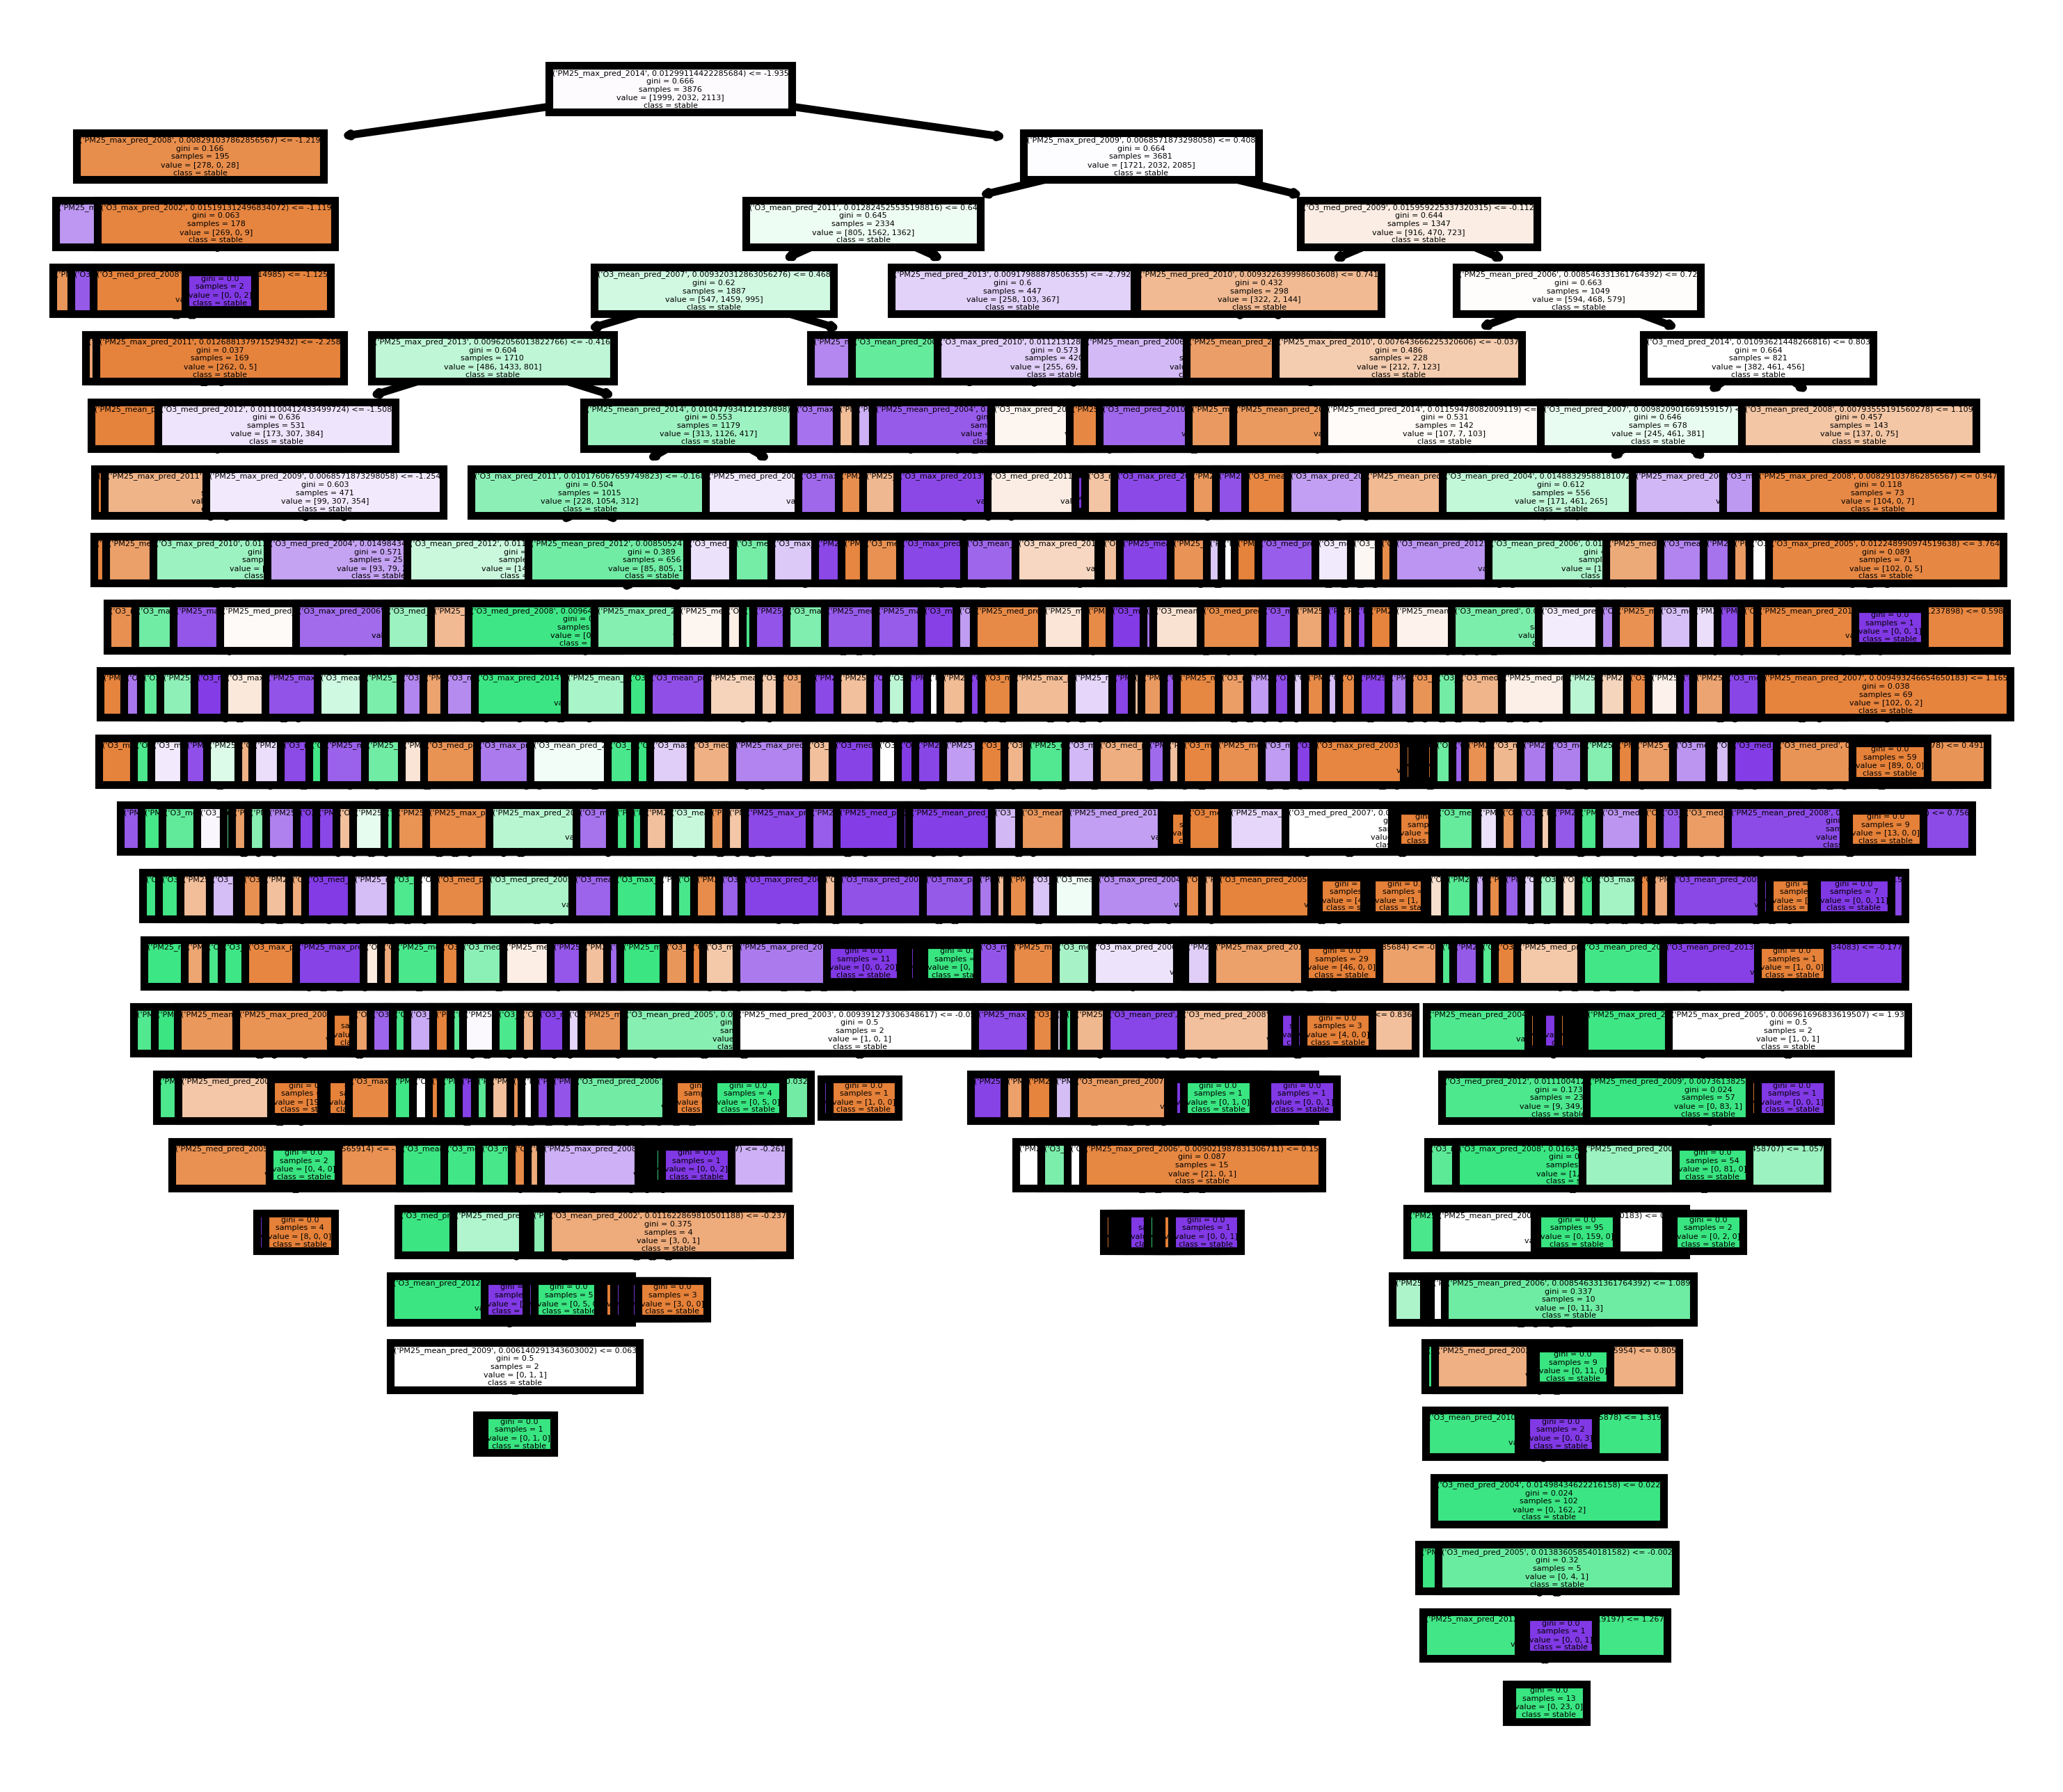

In [38]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(brc.estimators_[0],
               feature_names = features, 
               class_names=df['recent_trend'],
               filled = True);
# plt.savefig('/content/drive/MyDrive/Final_Project/tree_SMOTE.png')


In [39]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    brc, X_test_scaled, y_test, n_repeats=10, random_state=1, n_jobs=2)

forest_importances = pd.Series(result.importances_mean)

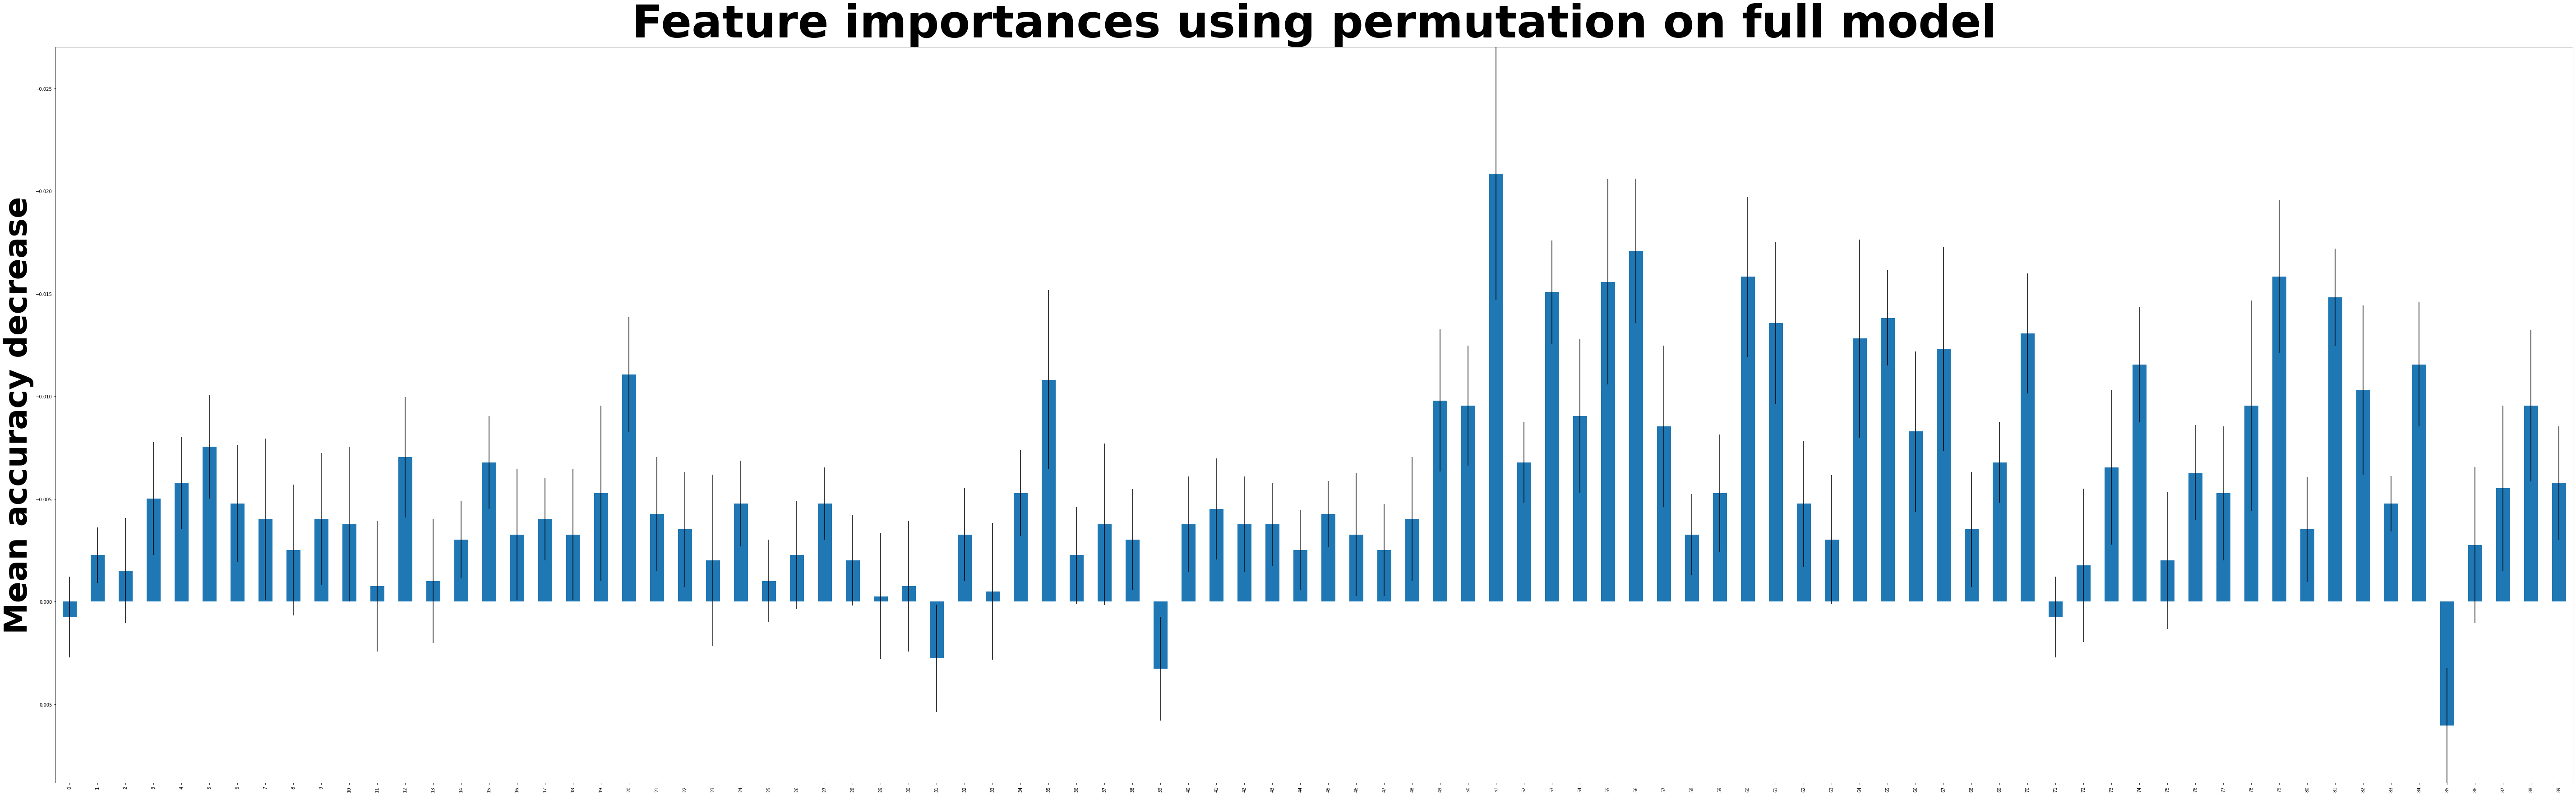

In [40]:
# import matplotlib.pylab as pylab

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model",fontdict={'fontsize': 100, 'fontweight': 'semibold'})
ax.set_ylabel("Mean accuracy decrease",fontdict={'fontsize': 70, 'fontweight': 'semibold'})
ax.invert_yaxis()
fig.set_size_inches(100,30)
plt.margins(x=0.00001,y=0.00001)


# plt.savefig('/content/drive/MyDrive/Final_Project/Forest_Importances')
plt.show()

In [ ]:
# # export data for visualizations

# viz_cols = ['FIPS', 'recent_trend', 'prediction_trend', 'O3_max_pred', 'PM25_max_pred']

# viz_df = df[viz_cols].copy()

# viz_df.head()

In [ ]:
# viz_df.to_sql('visualization_data', engine, if_exists='replace', index=False)